In [1]:
# Install required packages
%pip install mysql
%pip install mysql-connector-python
%pip install matplotlib
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# MySQL connector for establishing database connections
# Error class helps catch and handle connection errors
import mysql.connector
from mysql.connector import Error

In [ ]:
# Function to create a connection to the MySQL database
def create_connection():
    try:
        conn = mysql.connector.connect(
            host='localhost',        # database host (usually 'localhost')
            user='root',             # your MySQL username
            password='---------',      # your MySQL password
            port=3306,               # default MySQL port
            database='restoranas_db' # the database you want to use
        )
        if conn.is_connected():
            print("Successfully connected to the database")
        return conn
    except Error as e:
        print(f"Connection failed: {e}")
        return None


# Function to safely close the database connection
def close_connection(conn):
    if conn.is_connected():
        conn.close()
        print("Connection closed successfully")


# Create connection and initialize cursor for executing SQL queries
conn = create_connection()
cursor = conn.cursor()

Successfully connected to the database


In [6]:
# Suppress unnecessary UserWarning messages related to SQLAlchemy
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message=".*only supports SQLAlchemy.*")

In [ ]:
# ===========================================
# ANALYSIS SECTIONS (SQL ↔ Pandas equivalents)
# Each section shows the same result via:
#   1) Pure SQL against MySQL
#   2) Pandas (joins, groupby, agg)
# Topics covered across sections:
#   - Joins, Group By, Aggregations (SUM/AVG/MIN/MAX)
#   - Filters: WHERE and HAVING
#   - Conditional logic: CASE / IF
#   - Sorting & pagination: ORDER BY, LIMIT, OFFSET
#   - Rounding (ROUND) and date/time filters
#   - Subqueries
# ===========================================

In [ ]:
# 01. Revenue by dish type (SQL)
#Query shows total revenue and sold quantity per dish category,
#helping identify which categories bring the highest turnover.
query = """
SELECT pt.pavadinimas AS patiekalo_tipas,
SUM(pp.kiekis * pat.kaina) AS pajamos_eur,
CAST(SUM(pp.kiekis)AS UNSIGNED) AS kiekis_vnt
FROM parduoti_patiekalai AS pp
JOIN patiekalai AS pat 
ON pat.id_patiekalai = pp.patiekalai_id
JOIN patiekalu_tipai AS pt 
ON pt.id_patiekalu_tipai = pat.patiekalu_tipai_id
GROUP BY pt.pavadinimas
ORDER BY pajamos_eur DESC;
"""
df = pd.read_sql(query, conn)
df

,patiekalo_tipas,pajamos_eur,kiekis_vnt
0,Grill patiekalai,3831.3,241
1,Žuvies patiekalai,1631.8,100
2,Pizza,248.6,23
3,Salotos,237.9,30
4,Makaronai,224.9,23
5,Vegetariški patiekalai,145.8,16
6,Sriubos,77.1,18
7,Karšti gėrimai,70.3,28
8,Gaivieji gėrimai,65.5,29
9,Alkoholiniai gėrimai,28.5,6


In [ ]:
# 01. Revenue by dish type (Pandas)
pp  = pd.read_sql("SELECT * FROM parduoti_patiekalai", conn)
pat = pd.read_sql("SELECT * FROM patiekalai", conn)
pt  = pd.read_sql("SELECT * FROM patiekalu_tipai", conn)

df = pp.merge(
    pat,
    left_on="patiekalai_id",
    right_on="id_patiekalai",
    how="inner",
    )

df = df.rename(columns={"pavadinimas": "patiekalas"})

df = df.merge(
    pt,
    left_on="patiekalu_tipai_id",
    right_on="id_patiekalu_tipai",
    how="inner",
    )

df = df.rename(columns={"pavadinimas": "patiekalo_tipas"})

df["pajamos_eur"] = df["kiekis"] * df["kaina"]

rez = (
    df.groupby("patiekalo_tipas", as_index=False)
    .agg(
        pajamos_eur=("pajamos_eur", "sum"),
        kiekis_vnt=("kiekis", "sum")
        )
    .sort_values("pajamos_eur", ascending=False)
)
rez["pajamos_eur"] = rez["pajamos_eur"].round(2)
rez.reset_index(drop=True, inplace=True)
rez

,patiekalo_tipas,pajamos_eur,kiekis_vnt
0,Grill patiekalai,3831.3,241
1,Žuvies patiekalai,1631.8,100
2,Pizza,248.6,23
3,Salotos,237.9,30
4,Makaronai,224.9,23
5,Vegetariški patiekalai,145.8,16
6,Sriubos,77.1,18
7,Karšti gėrimai,70.3,28
8,Gaivieji gėrimai,65.5,29
9,Alkoholiniai gėrimai,28.5,6


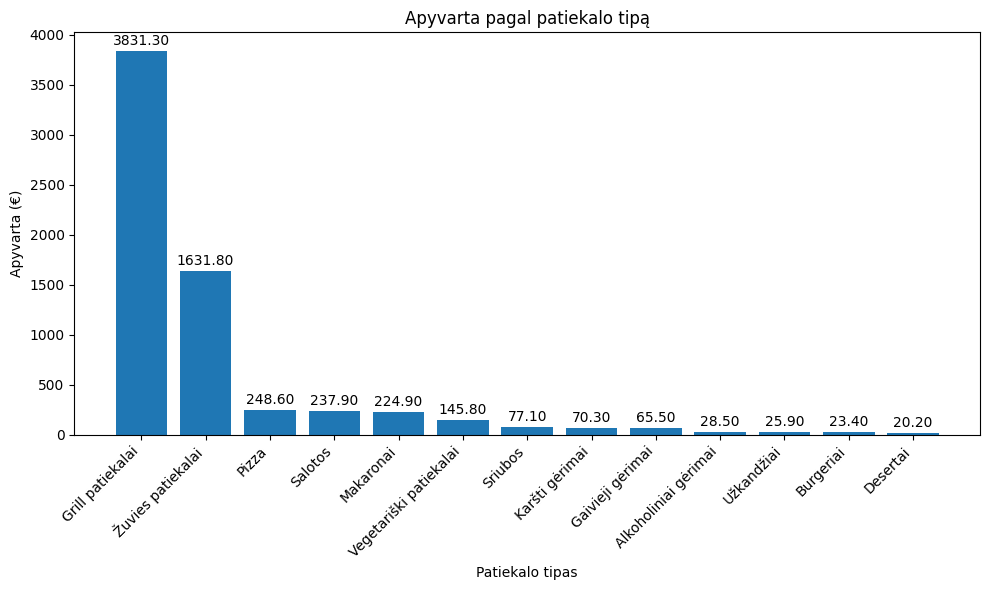

In [11]:
# Visualization: revenue by dish type
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(rez["patiekalo_tipas"], rez["pajamos_eur"])

ax.set_xlabel("Patiekalo tipas")
ax.set_ylabel("Apyvarta (€)")
ax.set_title("Apyvarta pagal patiekalo tipą")
plt.xticks(rotation=45, ha="right")

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 30, 
        f"{height:.2f}", 
        ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()

In [ ]:
#02_top10_dishes (SQL)
#Retrieves the Top 10 dishes ranked by total revenue and shows quantity sold.
query = """
SELECT pat.pavadinimas,
SUM(pp.kiekis * pat.kaina) AS pajamos_eur,
CAST(SUM(pp.kiekis) AS UNSIGNED) AS parduota_vnt
FROM parduoti_patiekalai AS pp
JOIN patiekalai AS pat 
ON pat.id_patiekalai = pp.patiekalai_id
GROUP BY pat.pavadinimas
ORDER BY pajamos_eur DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

,pavadinimas,pajamos_eur,parduota_vnt
0,Grill jautienos antrekotas,1592.0,80
1,Grill lašiša,1303.5,79
2,Tunas medium rare,769.7,43
3,Lašiša su sviesto padažu,453.6,28
4,Kiaulienos šašlykas,325.0,26
5,Krevetės česnakiniame svieste,203.0,14
6,Grill vištienos krūtinėlė,195.5,17
7,Kepta menkė,166.8,12
8,Grill daržovės,165.9,21
9,Tofu stir-fry,138.0,15


In [13]:
#02_top10_dishes (Pandas)
pp  = pd.read_sql("SELECT * FROM parduoti_patiekalai", conn)
pat = pd.read_sql("SELECT * FROM patiekalai", conn)

df = pp.merge(
    pat, left_on="patiekalai_id", 
    right_on="id_patiekalai", 
    how="inner")

df["pajamos_eur"] = df["kiekis"] * df["kaina"]

rez = (
    df.groupby("pavadinimas",as_index=False)
    .agg(
        pajamos_eur=("pajamos_eur", "sum"),
        kiekis_vnt=("kiekis", "sum")
        )
    .sort_values("pajamos_eur", ascending=False)
)
rez.reset_index(drop=True, inplace=True)
rez["pajamos_eur"] = rez["pajamos_eur"].round(2)
rez.head(10)

,pavadinimas,pajamos_eur,kiekis_vnt
0,Grill jautienos antrekotas,1592.0,80
1,Grill lašiša,1303.5,79
2,Tunas medium rare,769.7,43
3,Lašiša su sviesto padažu,453.6,28
4,Kiaulienos šašlykas,325.0,26
5,Krevetės česnakiniame svieste,203.0,14
6,Grill vištienos krūtinėlė,195.5,17
7,Kepta menkė,166.8,12
8,Grill daržovės,165.9,21
9,Tofu stir-fry,138.0,15


In [15]:
#03_dishes_last_Xdays(SQL)
#Lists dishes (with categories) by revenue over the last X days, filtering out items below a revenue threshold.
query = """
SELECT 
pt.pavadinimas AS patiekalo_tipas,
pat.pavadinimas AS patiekalas,
ROUND(SUM(pp.kiekis * pat.kaina), 2) AS pajamos_eur
FROM parduoti_patiekalai AS pp
JOIN patiekalai AS pat 
ON pat.id_patiekalai = pp.patiekalai_id
JOIN patiekalu_tipai AS pt
ON pt.id_patiekalu_tipai = pat.patiekalu_tipai_id
JOIN pardavimai AS p
ON p.id_pardavimai = pp.pardavimai_id
WHERE p.data_laikas >= CURDATE() - INTERVAL 14 DAY
GROUP BY pt.pavadinimas, pat.pavadinimas
HAVING SUM(pp.kiekis * pat.kaina) > 10
ORDER BY pajamos_eur DESC;
"""
df = pd.read_sql(query, conn)
df

,patiekalo_tipas,patiekalas,pajamos_eur
0,Žuvies patiekalai,Kepta menkė,13.9
1,Grill patiekalai,Grill vištienos krūtinėlė,11.5


In [17]:
#03_dishes_last_Xdays(Pandas)
pp   = pd.read_sql("SELECT * FROM parduoti_patiekalai", conn)
pat  = pd.read_sql("SELECT * FROM patiekalai", conn)
pt   = pd.read_sql("SELECT * FROM patiekalu_tipai", conn)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)

df = pp.merge(
    pat,
    left_on="patiekalai_id",
    right_on="id_patiekalai",
    how="inner",
)

df = df.rename(columns={"pavadinimas": "patiekalas"})

df = df.merge(
    pt,
    left_on="patiekalu_tipai_id",
    right_on="id_patiekalu_tipai",
    how="left",
)

df = df.rename(columns={"pavadinimas": "patiekalo_tipas"})

df = df.merge(
    pard,
    left_on="pardavimai_id",
    right_on="id_pardavimai",
    how="inner"
)

df["data_laikas"] = pd.to_datetime(df["data_laikas"])
df = df[df["data_laikas"] >= pd.Timestamp.now() - pd.Timedelta(days=14)]

df["pajamos_eur"] = df["kiekis"] * df["kaina"]

rez = (
    df.groupby(["patiekalo_tipas", "patiekalas"], as_index=False)
    .agg(pajamos_eur=("pajamos_eur", "sum"))
)

rez = rez[rez["pajamos_eur"] > 10]
rez = rez.sort_values("pajamos_eur", ascending=False)
rez["pajamos_eur"] = rez["pajamos_eur"].round(2)

rez.reset_index(drop=True, inplace=True)
rez 

,patiekalo_tipas,patiekalas,pajamos_eur
0,Žuvies patiekalai,Kepta menkė,13.9
1,Grill patiekalai,Grill vištienos krūtinėlė,11.5


In [18]:
#04_avg_check_by_customer_type(SQL)
#Computes average check and transaction count per customer type to compare spending behavior.
query = """
SELECT COALESCE(kt.pavadinimas, 'Nepriskirtas') AS klientu_tipas,
ROUND(AVG(p.suma_eur), 2) AS vid_cekio_suma,
COUNT(*) AS cekiu_sk
FROM pardavimai AS p
JOIN apsilankymai AS a 
ON a.id_apsilankymai = p.apsilankymai_id
LEFT JOIN klientai AS k 
ON k.id_klientai = a.klientai_id
LEFT JOIN klientu_tipai AS kt 
ON kt.id_klientu_tipai = k.klientu_tipai_id
GROUP BY COALESCE(kt.pavadinimas, 'Nepriskirtas')
ORDER BY vid_cekio_suma DESC;
"""
df = pd.read_sql(query, conn)
df

,klientu_tipas,vid_cekio_suma,cekiu_sk
0,Įmonė,185.19,10
1,Turistas,72.22,6
2,Lojalus,55.65,40
3,Naujas,55.63,15
4,Nepriskirtas,44.34,29


In [19]:
#04_avg_check_by_customer_type(Pandas)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)
ap   = pd.read_sql("SELECT * FROM apsilankymai", conn)
k    = pd.read_sql("SELECT * FROM klientai", conn)
kt   = pd.read_sql("SELECT * FROM klientu_tipai", conn)

df = pard.merge(
    ap,
    left_on="apsilankymai_id",
    right_on="id_apsilankymai",
    how="inner"
)

df = df.merge(
    k,
    left_on="klientai_id",
    right_on="id_klientai",
    how="left"
)

df = df.merge(
    kt,
    left_on="klientu_tipai_id",
    right_on="id_klientu_tipai",
    how="left"
)

df = df.rename(columns={"pavadinimas": "klientu_tipas"})

df["klientu_tipas"] = df["klientu_tipas"].fillna("Nepriskirtas")

rez = (
    df.groupby("klientu_tipas", as_index=False)
      .agg(
          vid_cekio_suma=("suma_eur", "mean"),
          cekiu_sk=("suma_eur", "count")
      )
      .sort_values("vid_cekio_suma", ascending=False)
)

rez["vid_cekio_suma"] = rez["vid_cekio_suma"].round(2)

rez.reset_index(drop=True, inplace=True)
rez

,klientu_tipas,vid_cekio_suma,cekiu_sk
0,Įmonė,185.19,10
1,Turistas,72.22,6
2,Lojalus,55.65,40
3,Naujas,55.63,15
4,Nepriskirtas,44.34,29


In [20]:
#05_customers_revenue_with_offset (SQL)
#Ranks customers by total spend and uses LIMIT/OFFSET to return the next page of results.
query = """
SELECT 
k.id_klientai AS klientas_id,
k.vardas_pavarde AS klientas,
SUM(p.suma_eur) AS bendra_suma
FROM pardavimai AS p
JOIN apsilankymai AS a 
ON a.id_apsilankymai = p.apsilankymai_id
JOIN klientai AS k 
ON k.id_klientai = a.klientai_id
GROUP BY k.id_klientai, k.vardas_pavarde
ORDER BY bendra_suma DESC
LIMIT 10
OFFSET 10;
"""
df = pd.read_sql(query, conn)
df

,klientas_id,klientas,bendra_suma
0,81,UAB Maisto Rojus,132.0
1,15,Vytautas Kairys,126.4
2,6,Laura Vaitkutė,122.7
3,50,Ugnė Sabaliauskaitė,122.6
4,85,MB Verslo Pietūs,118.3
5,14,Greta Pociūtė,109.6
6,30,Aistė Navickaitė,109.5
7,94,Maria Rossi,102.4
8,83,UAB Biuro Pietūs,97.4
9,92,Anna Müller,96.8


In [21]:
#05_customers_revenue_with_offset (Pandas)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)
ap = pd.read_sql("SELECT * FROM apsilankymai", conn)
k = pd.read_sql("SELECT * FROM klientai", conn)

df = pard.merge(
    ap,
    left_on="apsilankymai_id",
    right_on="id_apsilankymai",
    how="inner",
)
df = df.merge(
    k,
    left_on="klientai_id",
    right_on="id_klientai",
    how="inner",
)

rez = (
    df.groupby(["id_klientai", "vardas_pavarde"], as_index=False)
      .agg(bendra_suma=("suma_eur", "sum"))
      .sort_values(["bendra_suma", "id_klientai"], ascending=[False, False])
)

rez = rez.rename(columns={
    "id_klientai": "klientas_id",
    "vardas_pavarde": "klientas"
})
rez.reset_index(drop=True, inplace=True)
rez.iloc[10:20]

,klientas_id,klientas,bendra_suma
10,81,UAB Maisto Rojus,132.0
11,15,Vytautas Kairys,126.4
12,6,Laura Vaitkutė,122.7
13,50,Ugnė Sabaliauskaitė,122.6
14,85,MB Verslo Pietūs,118.3
15,14,Greta Pociūtė,109.6
16,30,Aistė Navickaitė,109.5
17,94,Maria Rossi,102.4
18,83,UAB Biuro Pietūs,97.4
19,92,Anna Müller,96.8


In [22]:
#06_top10_individual_customers (SQL)
#Retrieves the Top 10 non-corporate customers by total spend, excluding company accounts.
query = """
SELECT 
k.id_klientai AS klientas_id,
k.vardas_pavarde AS klientas,
kt.pavadinimas,
SUM(p.suma_eur) AS bendra_suma
FROM pardavimai AS p
JOIN apsilankymai AS a
ON a.id_apsilankymai = p.apsilankymai_id
JOIN klientai AS k
ON k.id_klientai = a.klientai_id
JOIN klientu_tipai AS kt
ON kt.id_klientu_tipai = k.klientu_tipai_id 
WHERE kt.pavadinimas IN ('Lojalus', 'Naujas', 'Atsitiktinis', 'Turistas')         
GROUP BY k.id_klientai, k.vardas_pavarde
ORDER BY bendra_suma DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)
df

,klientas_id,klientas,pavadinimas,bendra_suma
0,9,Rokas Šimkus,Lojalus,248.9
1,12,Rūta Norkutė,Lojalus,188.6
2,3,Mantas Jankauskas,Lojalus,132.9
3,15,Vytautas Kairys,Lojalus,126.4
4,6,Laura Vaitkutė,Lojalus,122.7
5,50,Ugnė Sabaliauskaitė,Naujas,122.6
6,14,Greta Pociūtė,Lojalus,109.6
7,30,Aistė Navickaitė,Lojalus,109.5
8,94,Maria Rossi,Turistas,102.4
9,33,Giedrius Paulauskas,Lojalus,96.8


In [23]:
#06_top10_individual_customers (Pandas)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)
ap = pd.read_sql("SELECT * FROM apsilankymai", conn)
k = pd.read_sql("SELECT * FROM klientai", conn)
kt = pd.read_sql("SELECT * FROM klientu_tipai", conn)

df = pard.merge(
    ap,
    left_on="apsilankymai_id",
    right_on="id_apsilankymai",
    how="inner",
)
df = df.merge(
    k,
    left_on="klientai_id",
    right_on="id_klientai",
    how="inner",
)
df = df.merge(
    kt,
    left_on="klientu_tipai_id",
    right_on="id_klientu_tipai",
    how="inner",
)

df = df.rename(columns={"pavadinimas": "klientu_tipas"})
df = df[df["klientu_tipas"].isin(["Lojalus", "Naujas", "Atsitiktinis", "Turistas"])]

rez = (
    df.groupby(["id_klientai", "vardas_pavarde"], as_index=False)
      .agg(bendra_suma=("suma_eur", "sum"))
      .sort_values(["bendra_suma", "id_klientai"], ascending=[False, True])
)

rez = rez.rename(columns={
    "id_klientai": "klientas_id",
    "vardas_pavarde": "klientas"
})
rez.reset_index(drop=True, inplace=True)
rez.head(10)

,klientas_id,klientas,bendra_suma
0,9,Rokas Šimkus,248.9
1,12,Rūta Norkutė,188.6
2,3,Mantas Jankauskas,132.9
3,15,Vytautas Kairys,126.4
4,6,Laura Vaitkutė,122.7
5,50,Ugnė Sabaliauskaitė,122.6
6,14,Greta Pociūtė,109.6
7,30,Aistė Navickaitė,109.5
8,94,Maria Rossi,102.4
9,33,Giedrius Paulauskas,96.8


In [24]:
#07_min_max_check_with_ids (SQL)
#Returns average, minimum, and maximum check values for a period, plus the IDs of the smallest and largest checks.
query = """
SELECT
ROUND(AVG(suma_eur), 2) AS vid_cekis,
MIN(suma_eur) AS min_cekis,
(SELECT id_pardavimai 
FROM pardavimai 
WHERE data_laikas >= CURDATE() - INTERVAL 30 DAY
ORDER BY suma_eur ASC 
LIMIT 1) AS min_cekio_id,
MAX(suma_eur) AS max_cekis,
(SELECT id_pardavimai 
FROM pardavimai 
WHERE data_laikas >= CURDATE() - INTERVAL 30 DAY
ORDER BY suma_eur DESC 
LIMIT 1) AS max_cekio_id
FROM pardavimai
WHERE data_laikas >= CURDATE() - INTERVAL 30 DAY;
"""
df = pd.read_sql(query, conn)
df

,vid_cekis,min_cekis,min_cekio_id,max_cekis,max_cekio_id
0,70.56,14.5,51,122.6,50


In [25]:
#07_min_max_check_with_ids (Pandas)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)

pard["data_laikas"] = pd.to_datetime(pard["data_laikas"])

df = pard[pard["data_laikas"] >= pd.Timestamp.now() - pd.Timedelta(days=30)]

vid_cekis = round(df["suma_eur"].mean(), 2)

min_idx = df["suma_eur"].idxmin()
min_cekis = df.loc[min_idx, "suma_eur"]
min_cekio_id = df.loc[min_idx, "id_pardavimai"]

max_idx = df["suma_eur"].idxmax()
max_cekis = df.loc[max_idx, "suma_eur"]
max_cekio_id = df.loc[max_idx, "id_pardavimai"]

rez = pd.DataFrame([{
    "vid_cekis": vid_cekis,
    "min_cekis": min_cekis,
    "min_cekio_id": min_cekio_id,
    "max_cekis": max_cekis,
    "max_cekio_id": max_cekio_id
}])

rez

,vid_cekis,min_cekis,min_cekio_id,max_cekis,max_cekio_id
0,70.56,14.5,51,122.6,50


In [26]:
#08_revenue_by_weekday(SQL)
#Sums revenue and check count by weekday to find the most profitable days.
query = """
SELECT DAYNAME(p.data_laikas) AS savaites_diena,
SUM(p.suma_eur) AS pardavimai_eur,
COUNT(*) AS cekių_sk
FROM pardavimai AS p
GROUP BY DAYNAME(p.data_laikas)
ORDER BY pardavimai_eur DESC;
"""
df = pd.read_sql(query, conn)
df

,savaites_diena,pardavimai_eur,cekių_sk
0,Wednesday,1294.5,18
1,Thursday,1121.5,18
2,Sunday,1010.7,16
3,Monday,942.4,15
4,Saturday,889.4,13
5,Tuesday,741.9,9
6,Friday,631.0,11


In [27]:
#08_revenue_by_weekday(Pandas)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)

pard["data_laikas"] = pd.to_datetime(pard["data_laikas"])

pard["weekday_name"] = pard["data_laikas"].dt.day_name()

rez = (
    pard.groupby("weekday_name",as_index=False)
    .agg(
        pardavimai_eur=("suma_eur", "sum"),
        cekiu_sk=("suma_eur", "count")
        )
    .sort_values("pardavimai_eur", ascending=False)
    .reset_index(drop=True)
)
rez

,weekday_name,pardavimai_eur,cekiu_sk
0,Wednesday,1294.5,18
1,Thursday,1121.5,18
2,Sunday,1010.7,16
3,Monday,942.4,15
4,Saturday,889.4,13
5,Tuesday,741.9,9
6,Friday,631.0,11


In [28]:
#09_sales_by_gender_and_loyalty(SQL)
#Breaks down revenue, number of checks, and average check by gender and loyalty status.
query = """
SELECT
IF(k.lytis = 'V', 'Vyras', 'Moteris') AS lytis,
IF(k.unikalus_kodas IS NULL, 'ne_lojalus', 'lojalus') AS lojalumas,
COUNT(p.id_pardavimai) AS cekiu_kiekis,
ROUND(SUM(p.suma_eur), 2) AS bendra_apyvarta,
ROUND(AVG(p.suma_eur), 2) AS vidutinis_cekis
FROM pardavimai AS p
JOIN apsilankymai AS a
ON a.id_apsilankymai = p.apsilankymai_id
JOIN klientai AS k
ON k.id_klientai = a.klientai_id
WHERE k.lytis IN ('V','M') 
GROUP BY lytis, lojalumas
ORDER BY bendra_apyvarta DESC;
"""
df = pd.read_sql(query, conn)
df

,lytis,lojalumas,cekiu_kiekis,bendra_apyvarta,vidutinis_cekis
0,Vyras,lojalus,28,1574.9,56.25
1,Moteris,lojalus,27,1485.4,55.01
2,Moteris,ne_lojalus,2,199.2,99.60
3,Vyras,ne_lojalus,3,191.9,63.97


In [29]:
#09_sales_by_gender_and_loyalty(Pandas)
pard = pd.read_sql("SELECT * FROM pardavimai", conn)
aps = pd.read_sql("SELECT * FROM apsilankymai", conn)
kl  = pd.read_sql("SELECT * FROM klientai", conn)

df = pard.merge(
    aps, 
    left_on="apsilankymai_id", 
    right_on="id_apsilankymai", 
    how="inner"
)

df = df.merge(
    kl, 
    left_on="klientai_id", 
    right_on="id_klientai", 
    how="inner"
)

df["lytis"] = df["lytis"].map({"V": "Vyras", "M": "Moteris"})

df["lojalumas"] = df["unikalus_kodas"].apply(
    lambda x: "lojalus" if pd.notna(x) else "ne_lojalus"
)

rez = (
    df.groupby(["lytis", "lojalumas"], as_index=False)
    .agg(
        cekiu_kiekis=("id_pardavimai", "count"),
        bendra_apyvarta=("suma_eur", "sum"),
        vidutinis_cekis=("suma_eur", "mean")
    )
)

rez["vidutinis_cekis"] = rez["vidutinis_cekis"].round(2)

rez = rez.sort_values("bendra_apyvarta", ascending=False).reset_index(drop=True)

rez

,lytis,lojalumas,cekiu_kiekis,bendra_apyvarta,vidutinis_cekis
0,Vyras,lojalus,28,1574.9,56.25
1,Moteris,lojalus,27,1485.4,55.01
2,Moteris,ne_lojalus,2,199.2,99.60
3,Vyras,ne_lojalus,3,191.9,63.97


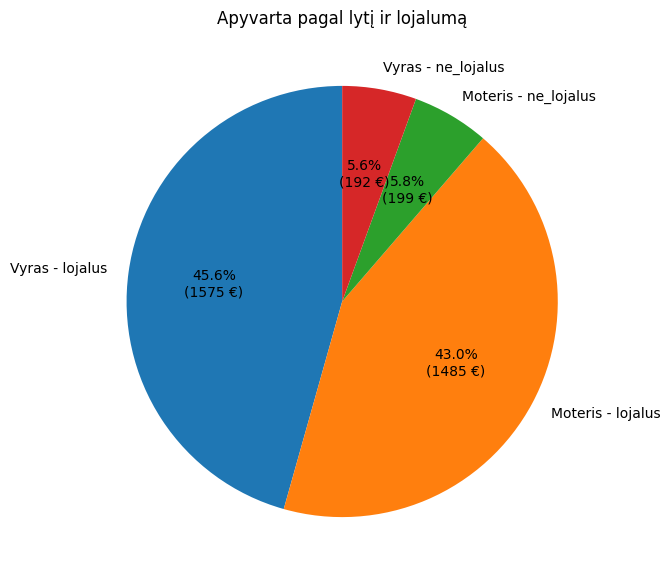

In [30]:
# Pie chart showing revenue breakdown by gender and loyalty groups
# - Labels combine gender and loyalty status (e.g., 'Male - loyal')
# - Each slice displays both percentage and absolute value (€)
# - startangle=90 rotates chart to start from the top
# - Added legend option in case labels overlap
import matplotlib.pyplot as plt

total = rez["bendra_apyvarta"].sum()

plt.figure(figsize=(7, 7))
plt.pie(
    rez["bendra_apyvarta"],
    labels=rez["lytis"] + " - " + rez["lojalumas"],
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct*total/100.0))} €)",
    startangle=90
)
plt.title("Apyvarta pagal lytį ir lojalumą")
plt.show()

In [31]:
#10_sales_by_age_group(SQL)
#Groups customers into age brackets using CASE and aggregates revenue and check count per group.
query = """
SELECT
CASE
WHEN TIMESTAMPDIFF(YEAR, k.gimimo_data, CURDATE()) BETWEEN 18 AND 24 THEN '18-24'
WHEN TIMESTAMPDIFF(YEAR, k.gimimo_data, CURDATE()) BETWEEN 25 AND 34 THEN '25-34'
WHEN TIMESTAMPDIFF(YEAR, k.gimimo_data, CURDATE()) BETWEEN 35 AND 44 THEN '35-44'
WHEN TIMESTAMPDIFF(YEAR, k.gimimo_data, CURDATE()) BETWEEN 45 AND 54 THEN '45-54'
WHEN TIMESTAMPDIFF(YEAR, k.gimimo_data, CURDATE()) >= 55 THEN '55+'
ELSE 'nežinoma'
END AS amziaus_grupe,
COUNT(*) AS cekiu_kiekis,
ROUND(SUM(p.suma_eur), 2) AS apyvarta
FROM pardavimai AS p
JOIN apsilankymai AS a 
ON a.id_apsilankymai = p.apsilankymai_id
LEFT JOIN klientai AS k 
ON k.id_klientai = a.klientai_id
GROUP BY amziaus_grupe
ORDER BY apyvarta DESC;
"""
df = pd.read_sql(query, conn)
df

,amziaus_grupe,cekiu_kiekis,apyvarta
0,nežinoma,45,3571.1
1,25-34,30,1582.2
2,35-44,22,1304.7
3,18-24,3,173.4


In [32]:
#10_sales_by_age_group(Pandas)
import numpy as np

p = pd.read_sql("SELECT * FROM pardavimai", conn)
a = pd.read_sql("SELECT * FROM apsilankymai", conn)
k = pd.read_sql("SELECT * FROM klientai", conn) 

df = (
    p.merge(
        a, 
        left_on="apsilankymai_id", 
        right_on="id_apsilankymai", 
        how="inner")
        )

df = df.merge(
    k,
    left_on="klientai_id", 
    right_on="id_klientai",    
    how="left"
    )

df["gimimo_data"] = pd.to_datetime(df["gimimo_data"])
siand = pd.Timestamp.today()
gim = df["gimimo_data"]

pries_gimt = (
    (gim.dt.month > siand.month) |
    ((gim.dt.month == siand.month) & (gim.dt.day > siand.day))
)


df["amzius"] = siand.year - gim.dt.year - pries_gimt.fillna(False).astype(int)


amz_grup = [
    (df["amzius"] >= 18) & (df["amzius"] <= 24),
    (df["amzius"] >= 25) & (df["amzius"] <= 34),
    (df["amzius"] >= 35) & (df["amzius"] <= 44),
    (df["amzius"] >= 45) & (df["amzius"] <= 54),
    (df["amzius"] >= 55),
]

grup = ["18-24", "25-34", "35-44", "45-54", "55+"]

df["amziaus_grupe"] = np.select(amz_grup, grup, default="nežinoma")

rez = (
    df.groupby("amziaus_grupe", as_index=False)
      .agg(
          cekiu_kiekis=("id_pardavimai", "count"),
          apyvarta=("suma_eur", "sum")
      )
      .sort_values("apyvarta", ascending=False)
      .reset_index(drop=True)
)
rez["apyvarta"] = rez["apyvarta"].round(2)
rez

,amziaus_grupe,cekiu_kiekis,apyvarta
0,nežinoma,45,3571.1
1,25-34,30,1582.2
2,35-44,22,1304.7
3,18-24,3,173.4


In [33]:
#11_top_customers_by_visits(SQL)
#Retrieves customers with the most visits and their total spend, including unidentified via COALESCE.
query = """
SELECT
COALESCE(k.vardas_pavarde, 'Neidentifikuotas') AS klientas,
COUNT(DISTINCT a.id_apsilankymai) AS apsilankymu_sk,
SUM(p.suma_eur) AS bendra_suma
FROM apsilankymai AS a
LEFT JOIN klientai AS k 
ON k.id_klientai = a.klientai_id
LEFT JOIN pardavimai AS p 
ON p.apsilankymai_id = a.id_apsilankymai
GROUP BY
COALESCE(k.vardas_pavarde, 'Neidentifikuotas')
ORDER BY apsilankymu_sk DESC, bendra_suma DESC
LIMIT 12;
"""
df = pd.read_sql(query, conn)
df

,klientas,apsilankymu_sk,bendra_suma
0,Neidentifikuotas,30,1328.1
1,Rokas Šimkus,3,248.9
2,Rūta Norkutė,3,188.6
3,Gabija Lukauskaitė,3,82.1
4,Mantas Jankauskas,2,132.9
5,Laura Vaitkutė,2,122.7
6,Greta Pociūtė,2,109.6
7,Tomas Stankevičius,2,92.3
8,Andrius Balčiūnas,2,71.0
9,Karolis Kavaliauskas,2,59.0


In [34]:
#11_top_customers_by_visits(Pandas)
a = pd.read_sql("SELECT * FROM apsilankymai", conn)
k = pd.read_sql("SELECT * FROM klientai", conn)
p = pd.read_sql("SELECT * FROM pardavimai", conn)

df = a.merge(
     k, left_on="klientai_id", 
     right_on="id_klientai", 
     how="left")
df = df.merge(
    p, 
    left_on="id_apsilankymai", 
    right_on="apsilankymai_id", 
    how="left")

df["klientas"] = df["vardas_pavarde"].fillna("Neidentifikuotas")

rez = (
    df.groupby(["klientas"], as_index=False)
      .agg(
          apsilankymu_sk=("id_apsilankymai", "nunique"),
          bendra_suma=("suma_eur", "sum")             
      )
)

rez = (
    rez.sort_values(["apsilankymu_sk", "bendra_suma"], ascending=[False, False])
       .reset_index(drop=True)
)
rez.head(12)

,klientas,apsilankymu_sk,bendra_suma
0,Neidentifikuotas,30,1328.1
1,Rokas Šimkus,3,248.9
2,Rūta Norkutė,3,188.6
3,Gabija Lukauskaitė,3,82.1
4,Mantas Jankauskas,2,132.9
5,Laura Vaitkutė,2,122.7
6,Greta Pociūtė,2,109.6
7,Tomas Stankevičius,2,92.3
8,Andrius Balčiūnas,2,71.0
9,Karolis Kavaliauskas,2,59.0


In [35]:
#12_sales_by_mealtime(SQL)
#Segments sales into lunch/dinner/other with CASE and aggregates revenue, check count, and average check.
query = """
SELECT 
CASE
WHEN TIME(data_laikas) BETWEEN '11:00:00' AND '15:00:00' THEN 'Pietūs'
WHEN TIME(data_laikas) BETWEEN '17:00:00' AND '22:00:00' THEN 'Vakarienė'
ELSE 'Kitas laikas'
END AS dienos_metas,
COUNT(*) AS cekiu_sk,
ROUND(AVG(suma_eur), 2) AS vid_cekio_suma,
SUM(suma_eur) AS pajamos
FROM pardavimai 
GROUP BY 
CASE
WHEN TIME(data_laikas) BETWEEN '11:00:00' AND '15:00:00' THEN 'Pietūs'
WHEN TIME(data_laikas) BETWEEN '17:00:00' AND '22:00:00' THEN 'Vakarienė'
ELSE 'Kitas laikas'
END
ORDER BY pajamos DESC;
"""
df = pd.read_sql(query, conn)
df

,dienos_metas,cekiu_sk,vid_cekio_suma,pajamos
0,Vakarienė,65,68.37,4444.2
1,Pietūs,35,62.49,2187.2


In [36]:
#12_sales_by_mealtime(Pandas)
p = pd.read_sql("SELECT * FROM pardavimai", conn)

p["data_laikas"] = pd.to_datetime(p["data_laikas"])

p["val"] = p["data_laikas"].dt.hour
p["min"] = p["data_laikas"].dt.minute

def dienos_metas_zod(val):
    if 11 <= val < 15:  
        return "Pietūs"
    elif 17 <= val < 22:    
        return "Vakarienė"
    else:
        return "Kitas laikas"

p["dienos_metas"] = p["val"].apply(dienos_metas_zod)

rez = (
    p.groupby("dienos_metas", as_index=False)
     .agg(
         cekiu_sk=("id_pardavimai", "count"),
         vid_cekio_suma=("suma_eur", "mean"),
         pajamos=("suma_eur", "sum")
     )
)

rez["vid_cekio_suma"] = rez["vid_cekio_suma"].round(2)

rez = rez.sort_values("pajamos", ascending=False).reset_index(drop=True)

rez

,dienos_metas,cekiu_sk,vid_cekio_suma,pajamos
0,Vakarienė,65,68.37,4444.2
1,Pietūs,35,62.49,2187.2


In [37]:
#13_top_hours_by_sales(SQL)
#Finds the top hours by revenue using HOUR(), filtering out low-volume hours with HAVING.
query = """
SELECT
HOUR(data_laikas) AS valanda,
COUNT(*) AS cekiu_kiekis,
SUM(suma_eur) AS apyvarta,
ROUND(AVG(suma_eur), 2) AS vidutinis_cekis
FROM pardavimai
GROUP BY HOUR(data_laikas)
HAVING COUNT(*) > 5
ORDER BY apyvarta DESC
LIMIT 5;   
"""
df = pd.read_sql(query, conn)
df

,valanda,cekiu_kiekis,apyvarta,vidutinis_cekis
0,19,24,1789.7,74.57
1,20,22,1504.4,68.38
2,18,19,1150.1,60.53
3,13,15,943.6,62.91
4,12,15,719.2,47.95


In [38]:
#13_top_hours_by_sales(Pandas)
p = pd.read_sql("SELECT * FROM pardavimai", conn)

p["data_laikas"] = pd.to_datetime(p["data_laikas"])

p["valanda"] = p["data_laikas"].dt.hour
rez = (
    p.groupby("valanda", as_index=False)
     .agg(
         cekiu_kiekis=("id_pardavimai", "count"),
         apyvarta=("suma_eur", "sum"), 
         vidutinis_cekis=("suma_eur", "mean")
     )
)

rez = rez[rez["cekiu_kiekis"] > 5]
rez["vidutinis_cekis"] = rez["vidutinis_cekis"].round(2)

rez = (rez.sort_values("apyvarta", ascending=False)
          .reset_index(drop=True))

rez.head(5)

,valanda,cekiu_kiekis,apyvarta,vidutinis_cekis
0,19,24,1789.7,74.57
1,20,22,1504.4,68.38
2,18,19,1150.1,60.53
3,13,15,943.6,62.91
4,12,15,719.2,47.95


In [39]:
#14_customers_above_avg_check(SQL)
#Finds customers whose average check exceeds the restaurant average (subquery + CROSS JOIN).
query = """
SELECT
t.vardas_pavarde,
ROUND(t.vidutinis_cekis, 2) AS vidutinis_cekis,
ROUND(rv.restorano_vidurkis, 2) AS restorano_vidurkis,
ROUND(t.vidutinis_cekis - rv.restorano_vidurkis, 2) AS skirtumas_eur
FROM (
SELECT 
k.id_klientai,
k.vardas_pavarde,
AVG(p.suma_eur) AS vidutinis_cekis
FROM klientai AS k
JOIN apsilankymai AS a 
ON a.klientai_id = k.id_klientai
JOIN pardavimai AS p   
ON p.apsilankymai_id = a.id_apsilankymai
GROUP BY k.id_klientai, k.vardas_pavarde
) t
CROSS JOIN (
SELECT AVG(suma_eur) AS restorano_vidurkis
FROM pardavimai
) rv
WHERE t.vidutinis_cekis > rv.restorano_vidurkis
ORDER BY skirtumas_eur DESC;
"""
df = pd.read_sql(query, conn)
df

,vardas_pavarde,vidutinis_cekis,restorano_vidurkis,skirtumas_eur
0,UAB Gardu Gardu,328.50,66.31,262.19
1,UAB Gourmet Partneriai,286.00,66.31,219.69
2,UAB Skanus Kampelis,245.80,66.31,179.49
3,MB Pietūs Darbuotojams,176.40,66.31,110.09
4,MB Skonio Kelias,168.50,66.31,102.19
5,UAB Skonio Fabrikas,164.80,66.31,98.49
6,UAB Restoranų Grupė,134.20,66.31,67.89
7,UAB Maisto Rojus,132.00,66.31,65.69
8,Vytautas Kairys,126.40,66.31,60.09
9,Ugnė Sabaliauskaitė,122.60,66.31,56.29


In [40]:
#14_customers_above_avg_check(Pandas)
k = pd.read_sql("SELECT * FROM klientai", conn)
a = pd.read_sql("SELECT * FROM apsilankymai", conn)
p = pd.read_sql("SELECT * FROM pardavimai", conn)

df = k.merge(
     a, 
     left_on="id_klientai", 
     right_on="klientai_id", 
     how="inner"
     )
df= df.merge(
    p, 
    left_on="id_apsilankymai", 
    right_on="apsilankymai_id", 
    how="inner"
    )

pagal_klienta = (
    df.groupby(["vardas_pavarde"], as_index=False)
      .agg(vidutinis_cekis=("suma_eur", "mean"))
)

restorano_vidurkis = p["suma_eur"].mean()

pagal_klienta["restorano_vidurkis"] = restorano_vidurkis
pagal_klienta["skirtumas_eur"] = pagal_klienta["vidutinis_cekis"] - restorano_vidurkis

rez = pagal_klienta[pagal_klienta["vidutinis_cekis"] > restorano_vidurkis]

rez["vidutinis_cekis"] = rez["vidutinis_cekis"].round(2)
rez["restorano_vidurkis"] = rez["restorano_vidurkis"].round(2)
rez["skirtumas_eur"] = rez["skirtumas_eur"].round(2)

rez = rez.sort_values("skirtumas_eur", ascending=False).reset_index(drop=True)

rez

C:\Users\marta\AppData\Local\Temp\ipykernel_4440\297853740.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez["vidutinis_cekis"] = rez["vidutinis_cekis"].round(2)
C:\Users\marta\AppData\Local\Temp\ipykernel_4440\297853740.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez["restorano_vidurkis"] = rez["restorano_vidurkis"].round(2)
C:\Users\marta\AppData\Local\Temp\ipykernel_4440\297853740.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,vardas_pavarde,vidutinis_cekis,restorano_vidurkis,skirtumas_eur
0,UAB Gardu Gardu,328.50,66.31,262.19
1,UAB Gourmet Partneriai,286.00,66.31,219.69
2,UAB Skanus Kampelis,245.80,66.31,179.49
3,MB Pietūs Darbuotojams,176.40,66.31,110.09
4,MB Skonio Kelias,168.50,66.31,102.19
5,UAB Skonio Fabrikas,164.80,66.31,98.49
6,UAB Restoranų Grupė,134.20,66.31,67.89
7,UAB Maisto Rojus,132.00,66.31,65.69
8,Vytautas Kairys,126.40,66.31,60.09
9,Ugnė Sabaliauskaitė,122.60,66.31,56.29


In [41]:
#15_top_summer_dishes(SQL)
#Lists the Top 5 best-selling dishes in summer (June–August) by revenue and quantity.
query = """
SELECT 
pat.pavadinimas,
SUM(pp.kiekis) AS kiekis_vnt,
ROUND(SUM(pp.kiekis * pat.kaina), 2) AS pajamos_eur
FROM parduoti_patiekalai AS pp
JOIN patiekalai AS pat 
ON pat.id_patiekalai = pp.patiekalai_id
JOIN pardavimai AS p 
ON p.id_pardavimai = pp.pardavimai_id
WHERE p.data_laikas >= '2025-06-01' AND p.data_laikas <  '2025-09-01'
GROUP BY pat.id_patiekalai, pat.pavadinimas
ORDER BY pajamos_eur DESC
LIMIT 5; 
"""
df = pd.read_sql(query, conn)
df

,pavadinimas,kiekis_vnt,pajamos_eur
0,Grill jautienos antrekotas,29.0,577.1
1,Tunas medium rare,27.0,483.3
2,Grill lašiša,22.0,363.0
3,Lašiša su sviesto padažu,10.0,162.0
4,Krevetės česnakiniame svieste,8.0,116.0


In [42]:
#15_top_summer_dishes(Pandas)
pp = pd.read_sql("SELECT * FROM parduoti_patiekalai", conn)
pat = pd.read_sql("SELECT * FROM patiekalai", conn)
p = pd.read_sql("SELECT * FROM pardavimai", conn)

p["data_laikas"] = pd.to_datetime(p["data_laikas"])

p_filt = p[(p["data_laikas"] >= "2025-06-01") & (p["data_laikas"] < "2025-09-01")]

df = pp.merge(
      pat, 
      left_on="patiekalai_id", 
      right_on="id_patiekalai", 
      how="inner"
      )
df= df.merge(
    p_filt, 
    left_on="pardavimai_id", 
    right_on="id_pardavimai", 
    how="inner"
    )


df["pajamos_eur"] = df["kiekis"] * df["kaina"]

rez = (
    df.groupby(["pavadinimas"], as_index=False)
      .agg(
          kiekis_vnt=("kiekis", "sum"),
          pajamos_eur=("pajamos_eur", "sum")
      )
)

rez["pajamos_eur"] = rez["pajamos_eur"].round(2)
rez = rez.sort_values("pajamos_eur", ascending=False).reset_index(drop=True)

rez.head(5)

,pavadinimas,kiekis_vnt,pajamos_eur
0,Grill jautienos antrekotas,29,577.1
1,Tunas medium rare,27,483.3
2,Grill lašiša,22,363.0
3,Lašiša su sviesto padažu,10,162.0
4,Krevetės česnakiniame svieste,8,116.0


In [ ]:
#This notebook successfully replicated all analytical SQL queries 
#both in raw SQL and in Pandas (using joins, groupby, and aggregations).  
#Visualizations (bar, pie charts) were added to highlight main insights.